In [1]:
import scipy.misc
import matplotlib.pyplot as plt
lena=scipy.misc.face()
plt.imshow(lena)

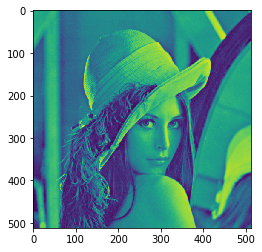

In [2]:
def lena():
    import pickle
    import numpy as np
    f = open('./lena.dat','rb')
    lena = np.array(pickle.load(f))
    f.close()
    return lena
plt.imshow(lena())

Text(0.5, 0, '$y$')

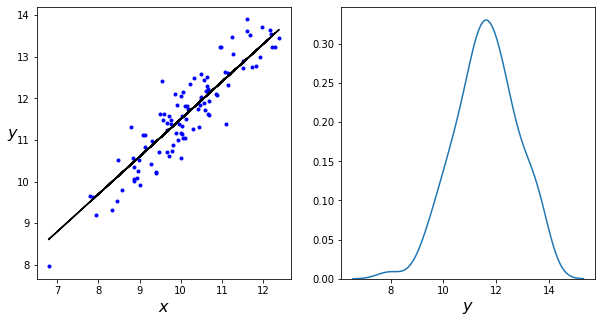

In [2]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)

In [4]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * x, sd=epsilon,observed=y)
    trace = pm.sample(10000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:45<00:00, 971.88draws/s] 


(130153.90731257971, 30.488569296369313)

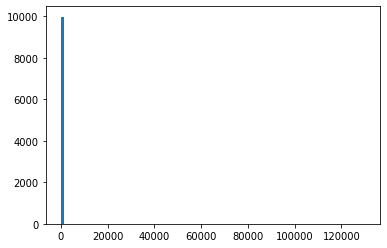

In [5]:
r = stats.halfcauchy.rvs(size=10000,loc=5,scale=2)
plt.hist(r,100)
np.max(r),np.mean(r)

In [32]:
help(scipy.stats.halfcauchy.rvs)

Help on method rvs in module scipy.stats._distn_infrastructure:

rvs(*args, **kwds) method of scipy.stats._continuous_distns.halfcauchy_gen instance
    Random variates of given type.
    
    Parameters
    ----------
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information).
    loc : array_like, optional
        Location parameter (default=0).
    scale : array_like, optional
        Scale parameter (default=1).
    size : int or tuple of ints, optional
        Defining number of random variates (default is 1).
    random_state : None or int or ``np.random.RandomState`` instance, optional
        If int or RandomState, use it for drawing the random variates.
        If None, rely on ``self.random_state``.
        Default is None.
    
    Returns
    -------
    rvs : ndarray or scalar
        Random variates of given `size`.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc99f1570b8>,
      dtype=object)

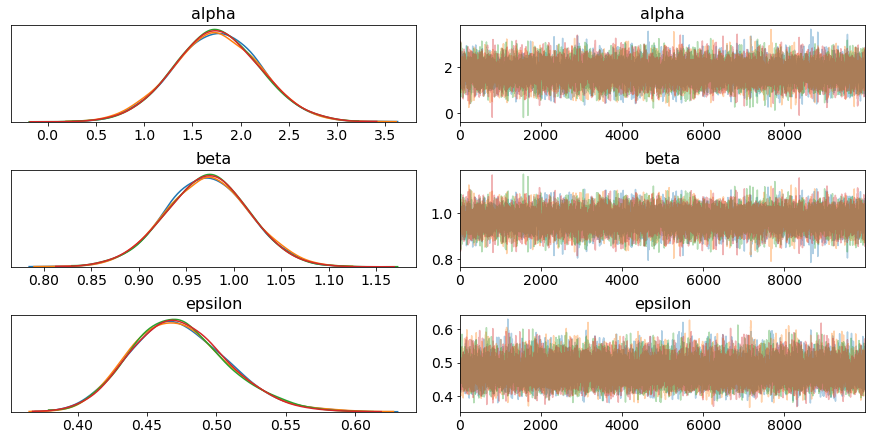

In [6]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc99b6161d0>,
      dtype=object)

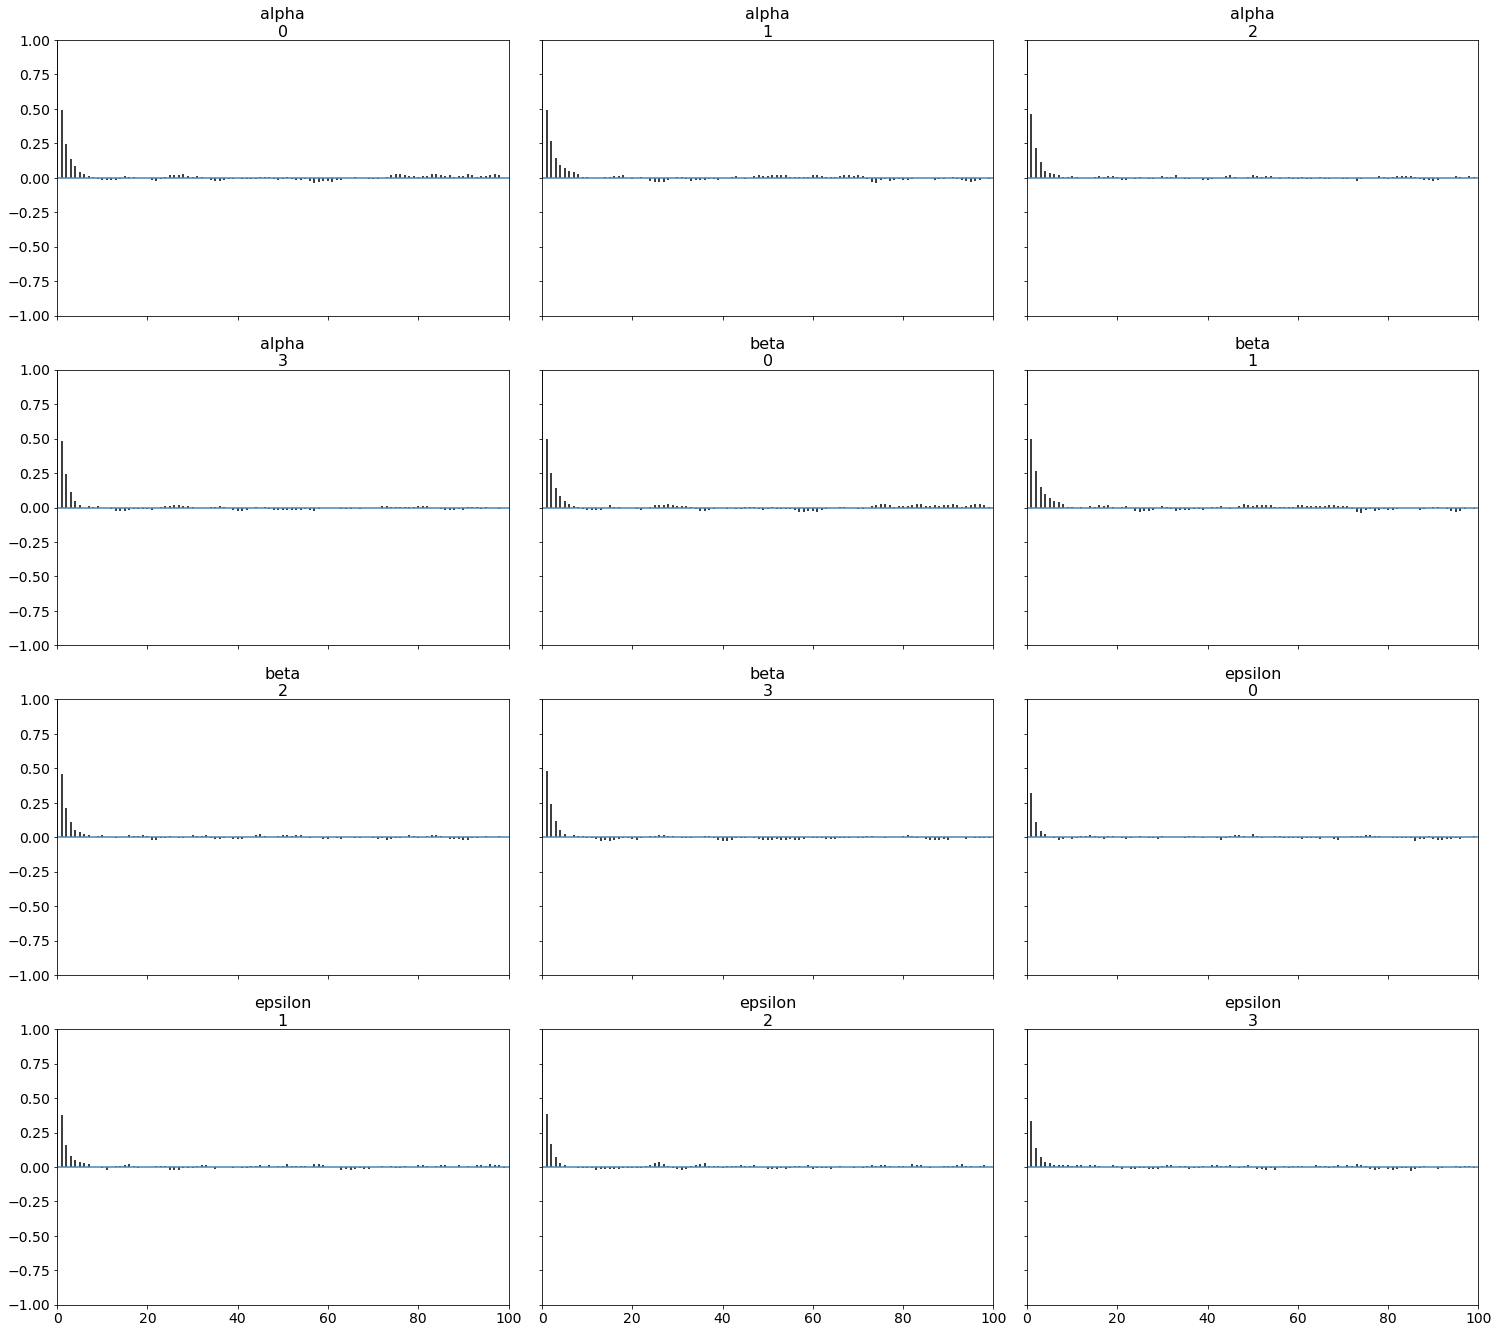

In [7]:
pm.autocorrplot(trace)

Text(0, 0.5, '$\\beta$')

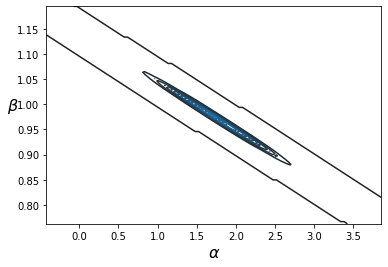

In [10]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

Text(0, 0.5, '$\\epsilon$')

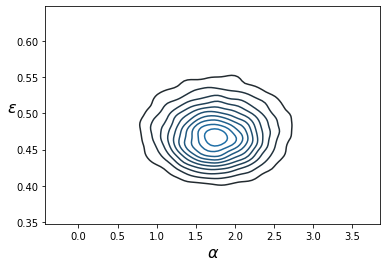

In [12]:
sns.kdeplot(trace['alpha'], trace['epsilon'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\epsilon$', fontsize=16, rotation=0)